In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [10]:
WINDOW_LENGTH = 256  # data window
STRIDE = 128        # stride
BATCH_SIZE = 64  # batch
EPOCHS = 100  # epoch
LEARNING_RATE = 0.0001  # lr
PROJ_DIM = 128  # embedding dimension

In [11]:
datapath = "../../../data/SisFall_dataset/" 

In [12]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [13]:
adl_activities = [f'D{str(i).zfill(2)}' for i in range(1, 20)]  # D01-D19
fall_activities = [f'F{str(i).zfill(2)}' for i in range(1, 16)]  # F01-F15

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

adult_subjects = [f'SA{str(i).zfill(2)}' for i in range(1, 24)]  # SA01-SA23
elderly_subjects = [f'SE{str(i).zfill(2)}' for i in range(1, 16)]  # SE01-SE15

train_sa = adult_subjects[:16]    # 16 subjects
val_sa = adult_subjects[16:19]    # 3 subjects
test_sa = adult_subjects[19:]     # 4 subjects

train_se = elderly_subjects[:10]  # 10 subjects
val_se = elderly_subjects[10:12]  # 2 subjects
test_se = elderly_subjects[12:]   # 3 subjects

train_split = train_sa + train_se
val_split = val_sa + val_se
test_split = test_sa + test_se

In [14]:
def read_sensor_file(filepath) :
   """
       first 6 columns : ADXL345 acc + ITG3200 gyro
   """
   with open(filepath, 'r') as file:
       content = file.read()

   content = content.replace(' ', '')  # delete blank
   rows = []

   for line in content.split(';\n'): 
       if line.strip():
           try:
               values = [float(x) for x in line.split(',')[:6]]
               rows.append(values)
           except (ValueError, IndexError):
               continue

   return np.array(rows)

In [15]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length].T
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [16]:
'''
   TRAIN DATA PREPARING PART
   ONLY "ADL"
'''
train_data_normal = []  
train_labels_normal = [] 

for subject in tqdm(train_split):  
   subject_dir = os.path.join(datapath, subject)
   
   if subject.startswith('SE') and subject != 'SE06':
       continue
       
   for activity in adl_activities:
       activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
       activity_files = glob.glob(activity_pattern)
       
       for file_path in activity_files:
           try:
               raw_data = read_sensor_file(file_path)
               if raw_data is not None and raw_data.shape[1] == 6:
                   sensor_data = raw_data
                   activity_labels = np.full(len(sensor_data), label2id[activity])
                   
                   windows_data, windows_labels = split_sequences(
                       sensor_data, activity_labels, 
                       WINDOW_LENGTH, STRIDE
                   )
                   
                   if windows_data is not None and len(windows_data) > 0:
                       train_data_normal.append(windows_data)
                       train_labels_normal.append(windows_labels)
                   
           except Exception as e: 
               print(f"Error processing file {file_path}: {e}")
               
train_data_normal = np.concatenate(train_data_normal, axis=0)
train_labels_normal = np.concatenate(train_labels_normal)

print (f"# of windows: {len(train_data_normal)}")
print (f"data shape: {train_data_normal.shape}")
print (f"labels shape: {train_labels_normal.shape}")
unique_labels, counts = np.unique(train_labels_normal, return_counts=True)
print (dict(zip(unique_labels, counts)))

100%|███████████████████████████████████████████| 26/26 [00:14<00:00,  1.85it/s]


# of windows: 37570
data shape: (37570, 6, 256)
labels shape: (37570,)
{0: 37570}


In [17]:
'''
   TEST DATA PREPARING PART
   ADL + FALL
'''
test_data = []
test_labels = []

for subject in tqdm(test_split):
   subject_dir = os.path.join(datapath, subject)
   
   is_elderly = subject.startswith('SE')
   
   if not (is_elderly and subject != 'SE06'): 
       for activity in adl_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")
   
   if not is_elderly or subject == 'SE06':
       for activity in fall_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print (f"# of windows: {len(test_data)}")
print (f"data shape: {test_data.shape}")
print (f"labels shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.14it/s]

# of windows: 15319
data shape: (15319, 6, 256)
labels shape: (15319,)
{0: 8764, 1: 6555}


In [18]:
train_data_shape = train_data_normal.shape
test_data_shape = test_data.shape

train_data_2d = train_data_normal.reshape(-1, train_data_normal.shape[-1])
test_data_2d = test_data.reshape(-1, test_data.shape[-1])

scaler = StandardScaler()
train_data_2d = scaler.fit_transform(train_data_2d)
test_data_2d = scaler.transform(test_data_2d)

train_data_normal = train_data_2d.reshape(train_data_shape)
test_data = test_data_2d.reshape(test_data_shape)

In [19]:
train_acc_normal = train_data_normal[..., :3] 
train_gyro_normal = train_data_normal[..., 3:]  
# (x, y, z)

test_acc = test_data[..., :3]  
test_gyro = test_data[..., 3:] 

train_dataset = tf.data.Dataset.from_tensor_slices((train_acc_normal, train_gyro_normal))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_acc, test_gyro), test_labels)
).batch(BATCH_SIZE)

print (f"train data - accel shape: {train_acc_normal.shape}")
print (f"train data - gyro shape: {train_gyro_normal.shape}")
print (f"test data - accel shape: {test_acc.shape}")
print (f"test data - gyro shape: {test_gyro.shape}")
print (f"# of training batches: {len(train_dataset)}")
print (f"# of test batches: {len(test_dataset)}")

train data - accel shape: (37570, 6, 3)
train data - gyro shape: (37570, 6, 253)
test data - accel shape: (15319, 6, 3)
test data - gyro shape: (15319, 6, 253)
# of training batches: 588
# of test batches: 240


------

In [20]:
# class Encoder(Model):
#     def __init__(self, in_feat, out_feat, num_encoders=1, use_skip=True):
#         super(Encoder, self).__init__()
#         self.use_skip = use_skip
#         self.num_encoders = num_encoders
        
#         for i in range(num_encoders):
#             setattr(self, f'conv1_{i}', layers.Conv1D(filters=out_feat*3, 
#                                                       kernel_size=7, padding='same', 
#                                                       activation='relu'))
#             setattr(self, f'maxpool1_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
#             setattr(self, f'conv2_{i}', layers.Conv1D(filters=out_feat*2, 
#                                                       kernel_size=5, padding='same', 
#                                                       activation='relu'))
#             setattr(self, f'maxpool2_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
#             setattr(self, f'conv3_{i}', layers.Conv1D(filters=out_feat*1, 
#                                                       kernel_size=3, padding='same', 
#                                                       activation='relu'))
    
#     def call(self, x, training=False):
#         for i in range(self.num_encoders):
#             if self.use_skip and i > 0:
#                 identity = x
            
#             x = getattr(self, f'conv1_{i}')(x)
#             x = getattr(self, f'maxpool1_{i}')(x)
#             x = getattr(self, f'conv2_{i}')(x)
#             x = getattr(self, f'maxpool2_{i}')(x)
#             x = getattr(self, f'conv3_{i}')(x)
            
#             if self.use_skip and i > 0:
#                 x = x + identity
        
#         return tf.reduce_mean(x, axis=1)

In [21]:
class Encoder(Model):
    def __init__(self, in_feat, out_feat, num_encoders=1):
        super(Encoder, self).__init__()
        
        # Initial convolution layers
        self.conv1 = layers.Conv1D(filters=256, kernel_size=7, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.LeakyReLU(0.2)
        self.pool1 = layers.MaxPooling1D(pool_size=2, padding='same')
        
        self.conv2 = layers.Conv1D(filters=128, kernel_size=5, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.LeakyReLU(0.2)
        self.pool2 = layers.MaxPooling1D(pool_size=2, padding='same')
        
        self.attention = layers.MultiHeadAttention(num_heads=8, key_dim=32)
        self.attention_norm = layers.LayerNormalization()
        
        self.conv3 = layers.Conv1D(filters=64, kernel_size=3, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.act3 = layers.LeakyReLU(0.2)
        
        self.global_pool = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(0.3)
        self.dense = layers.Dense(out_feat)
    
    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        attention_output = self.attention(x, x, x)
        x = self.attention_norm(x + attention_output)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        
        x = self.global_pool(x)
        x = self.dropout(x, training=training)
        x = self.dense(x)
        
        return x

In [22]:
# class CAGE(Model):
#     def __init__(self, n_feat=6, proj_dim=128):
#         super(CAGE, self).__init__()
#         self.proj_dim = proj_dim
        
#         self.enc_A = Encoder(n_feat, 64)
#         self.enc_G = Encoder(n_feat, 64)
        
#         if self.proj_dim > 0:
#             self.proj_A = layers.Dense(proj_dim, use_bias=False)
#             self.proj_G = layers.Dense(proj_dim, use_bias=False)
        
#         self.temperature = tf.Variable(0.1, trainable=True)
    
#     def call(self, x_accel, x_gyro, return_feat=False, training=False):
#         f_accel = self.enc_A(x_accel, training=training)
#         f_gyro = self.enc_G(x_gyro, training=training)
        
#         if self.proj_dim > 0:
#             e_accel = self.proj_A(f_accel)
#             e_gyro = self.proj_G(f_gyro)
#         else:
#             e_accel = f_accel
#             e_gyro = f_gyro
        
#         e_accel = tf.math.l2_normalize(e_accel, axis=1)
#         e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
#         sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
#         if return_feat:
#             return sim_matrix, (e_accel, e_gyro)
        
#         return sim_matrix

In [23]:
class CAGE(Model):
    def __init__(self, n_feat=6, proj_dim=128):
        super(CAGE, self).__init__()
        self.proj_dim = proj_dim
        
        # encoders
        self.enc_A = Encoder(n_feat, 64)
        self.enc_G = Encoder(n_feat, 64)
        
        if self.proj_dim > 0:
            self.proj_A = tf.keras.Sequential([
                layers.Dense(proj_dim * 2, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Dense(proj_dim, use_bias=False)
            ])
            self.proj_G = tf.keras.Sequential([
                layers.Dense(proj_dim * 2, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Dense(proj_dim, use_bias=False)
            ])
        
        self.temperature = tf.Variable(0.5, trainable=True) # 0.07 -> 0.5
    
    def call(self, x_accel, x_gyro, return_feat=False, training=False):
        f_accel = self.enc_A(x_accel, training=training)
        f_gyro = self.enc_G(x_gyro, training=training)
        
        if self.proj_dim > 0:
            e_accel = self.proj_A(f_accel)
            e_gyro = self.proj_G(f_gyro)
        else:
            e_accel = f_accel
            e_gyro = f_gyro
        
        e_accel = tf.math.l2_normalize(e_accel, axis=1)
        e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
        sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
        if return_feat:
            return sim_matrix, (e_accel, e_gyro)
        
        return sim_matrix

In [24]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9
)

model = CAGE(proj_dim=PROJ_DIM)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [25]:
# # @tf.function
# # def contrastive_loss(logits):
# #     """NT-Xent Loss"""
# #     batch_size = tf.shape(logits)[0]
    
# #     labels = tf.eye(batch_size) # diagonal matrix 
    
# #     '''
# #         loss calculating using CrossEntropy
# #     '''
# #     loss = tf.keras.losses.categorical_crossentropy(
# #         labels, 
# #         tf.nn.softmax(logits, axis=-1), 
# #         from_logits=False
# #     )
    
# #     return tf.reduce_mean(loss)

# def contrastive_loss(sim_matrix):
#     batch_size = tf.shape(sim_matrix)[0]
    
#     labels = tf.eye(batch_size)
    
#     loss_1 = tf.keras.losses.categorical_crossentropy(
#         labels,
#         tf.nn.softmax(sim_matrix, axis=1),
#         from_logits=False
#     )
    
#     loss_2 = tf.keras.losses.categorical_crossentropy(
#         labels,
#         tf.nn.softmax(sim_matrix, axis=0),
#         from_logits=False
#     )
    
#     total_loss = (loss_1 + loss_2) / 2
#     return tf.reduce_mean(total_loss)

In [26]:
def contrastive_loss(sim_matrix, temperature=0.5):
    batch_size = tf.shape(sim_matrix)[0]
    
    pos_mask = tf.eye(batch_size)
    pos_sim = tf.reduce_sum(sim_matrix * pos_mask, axis=1)
    
    # Hard negative mining
    neg_mask = 1 - pos_mask
    neg_sim = sim_matrix * neg_mask - pos_mask * 1e9
    hardest_neg_sim = tf.reduce_max(neg_sim, axis=1)
    
    # InfoNCE loss with numerical stability
    logits = tf.concat([pos_sim[:, None], neg_sim], axis=1)
    labels = tf.zeros(batch_size, dtype=tf.int32)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits/temperature)
    
    return tf.reduce_mean(loss)

In [27]:
# @tf.function
# def train_step(model, optimizer, x_accel, x_gyro):
#     with tf.GradientTape() as tape:
#         sim_matrix, (e_accel, e_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
#         loss = contrastive_loss(sim_matrix)
    
#     gradients = tape.gradient(loss, model.trainable_variables)
#     gradients = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in gradients]
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     return loss

In [28]:
@tf.function
def train_step(model, optimizer, x_accel, x_gyro):
    with tf.GradientTape() as tape:
        sim_matrix, (e_accel, e_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
        loss = contrastive_loss(sim_matrix)
        
        loss = tf.where(tf.math.is_finite(loss), loss, 1.0)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_norm(g, 0.5) if g is not None else g for g in gradients] # <- gradient clipping
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

----

In [29]:
print (train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 6, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6, 253), dtype=tf.float64, name=None))>


In [30]:
train_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_losses = []
    
    for acc_batch, gyro_batch in tqdm(train_dataset, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        loss = train_step(model, optimizer, acc_batch, gyro_batch)  
        epoch_losses.append(loss.numpy())
    
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    print (f"mean value of loss : {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print (f"best loss achieved : {best_loss:.4f}")

        
print("END THE LEARNING")
print(f"final best loss: {best_loss:.4f}")

Epoch 1/100: 100%|████████████████████████████| 588/588 [00:33<00:00, 17.35it/s]


mean value of loss : 2.7209
best loss achieved : 2.7209


Epoch 2/100: 100%|████████████████████████████| 588/588 [00:23<00:00, 24.92it/s]


mean value of loss : 1.7791
best loss achieved : 1.7791


Epoch 3/100: 100%|████████████████████████████| 588/588 [00:23<00:00, 24.98it/s]


mean value of loss : 1.4669
best loss achieved : 1.4669


Epoch 4/100: 100%|████████████████████████████| 588/588 [00:23<00:00, 24.99it/s]


mean value of loss : 1.3246
best loss achieved : 1.3246


Epoch 5/100: 100%|████████████████████████████| 588/588 [00:21<00:00, 27.51it/s]


mean value of loss : 1.2024
best loss achieved : 1.2024


Epoch 6/100: 100%|████████████████████████████| 588/588 [00:22<00:00, 26.36it/s]


mean value of loss : 1.1476
best loss achieved : 1.1476


Epoch 7/100: 100%|████████████████████████████| 588/588 [00:21<00:00, 26.74it/s]


mean value of loss : 1.0659
best loss achieved : 1.0659


Epoch 8/100: 100%|████████████████████████████| 588/588 [00:19<00:00, 29.74it/s]


mean value of loss : 1.0327
best loss achieved : 1.0327


Epoch 9/100: 100%|████████████████████████████| 588/588 [00:22<00:00, 26.00it/s]


mean value of loss : 1.0349


Epoch 10/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.23it/s]


mean value of loss : 0.9690
best loss achieved : 0.9690


Epoch 11/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.78it/s]


mean value of loss : 0.8938
best loss achieved : 0.8938


Epoch 12/100: 100%|███████████████████████████| 588/588 [00:21<00:00, 26.79it/s]


mean value of loss : 0.8913
best loss achieved : 0.8913


Epoch 13/100: 100%|███████████████████████████| 588/588 [00:21<00:00, 27.64it/s]


mean value of loss : 0.8849
best loss achieved : 0.8849


Epoch 14/100: 100%|███████████████████████████| 588/588 [00:21<00:00, 27.14it/s]


mean value of loss : 0.8393
best loss achieved : 0.8393


Epoch 15/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 26.42it/s]


mean value of loss : 0.7780
best loss achieved : 0.7780


Epoch 16/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 26.12it/s]


mean value of loss : 0.7446
best loss achieved : 0.7446


Epoch 17/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.83it/s]


mean value of loss : 0.7393
best loss achieved : 0.7393


Epoch 18/100: 100%|███████████████████████████| 588/588 [00:30<00:00, 19.53it/s]


mean value of loss : 0.7158
best loss achieved : 0.7158


Epoch 19/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.22it/s]


mean value of loss : 0.6944
best loss achieved : 0.6944


Epoch 20/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.14it/s]


mean value of loss : 0.7046


Epoch 21/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.42it/s]


mean value of loss : 0.6864
best loss achieved : 0.6864


Epoch 22/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 22.35it/s]


mean value of loss : 0.6201
best loss achieved : 0.6201


Epoch 23/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.47it/s]


mean value of loss : 0.6107
best loss achieved : 0.6107


Epoch 24/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.07it/s]


mean value of loss : 0.5888
best loss achieved : 0.5888


Epoch 25/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 25.76it/s]


mean value of loss : 0.5698
best loss achieved : 0.5698


Epoch 26/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 22.93it/s]


mean value of loss : 0.5475
best loss achieved : 0.5475


Epoch 27/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.22it/s]


mean value of loss : 0.5495


Epoch 28/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 23.59it/s]


mean value of loss : 0.5521


Epoch 29/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 22.99it/s]


mean value of loss : 0.5369
best loss achieved : 0.5369


Epoch 30/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.10it/s]


mean value of loss : 0.5126
best loss achieved : 0.5126


Epoch 31/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 21.95it/s]


mean value of loss : 0.4995
best loss achieved : 0.4995


Epoch 32/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.92it/s]


mean value of loss : 0.4833
best loss achieved : 0.4833


Epoch 33/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 23.86it/s]


mean value of loss : 0.4805
best loss achieved : 0.4805


Epoch 34/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.17it/s]


mean value of loss : 0.4695
best loss achieved : 0.4695


Epoch 35/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 25.56it/s]


mean value of loss : 0.4551
best loss achieved : 0.4551


Epoch 36/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.50it/s]


mean value of loss : 0.4505
best loss achieved : 0.4505


Epoch 37/100: 100%|███████████████████████████| 588/588 [00:28<00:00, 20.62it/s]


mean value of loss : 0.4409
best loss achieved : 0.4409


Epoch 38/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.59it/s]


mean value of loss : 0.4354
best loss achieved : 0.4354


Epoch 39/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 21.93it/s]


mean value of loss : 0.4378


Epoch 40/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.41it/s]


mean value of loss : 0.4226
best loss achieved : 0.4226


Epoch 41/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 22.99it/s]


mean value of loss : 0.4115
best loss achieved : 0.4115


Epoch 42/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 22.63it/s]


mean value of loss : 0.4119


Epoch 43/100: 100%|███████████████████████████| 588/588 [00:28<00:00, 20.29it/s]


mean value of loss : 0.4091
best loss achieved : 0.4091


Epoch 44/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 23.91it/s]


mean value of loss : 0.4043
best loss achieved : 0.4043


Epoch 45/100: 100%|███████████████████████████| 588/588 [00:20<00:00, 28.39it/s]


mean value of loss : 0.3933
best loss achieved : 0.3933


Epoch 46/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.57it/s]


mean value of loss : 0.3938


Epoch 47/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.96it/s]


mean value of loss : 0.3885
best loss achieved : 0.3885


Epoch 48/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.12it/s]


mean value of loss : 0.3878
best loss achieved : 0.3878


Epoch 49/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.26it/s]


mean value of loss : 0.3820
best loss achieved : 0.3820


Epoch 50/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.40it/s]


mean value of loss : 0.3810
best loss achieved : 0.3810


Epoch 51/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.76it/s]


mean value of loss : 0.3788
best loss achieved : 0.3788


Epoch 52/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 25.97it/s]


mean value of loss : 0.3739
best loss achieved : 0.3739


Epoch 53/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.67it/s]


mean value of loss : 0.3756


Epoch 54/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 25.65it/s]


mean value of loss : 0.3707
best loss achieved : 0.3707


Epoch 55/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.85it/s]


mean value of loss : 0.3642
best loss achieved : 0.3642


Epoch 56/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.08it/s]


mean value of loss : 0.3624
best loss achieved : 0.3624


Epoch 57/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 25.38it/s]


mean value of loss : 0.3562
best loss achieved : 0.3562


Epoch 58/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 26.23it/s]


mean value of loss : 0.3609


Epoch 59/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.23it/s]


mean value of loss : 0.3553
best loss achieved : 0.3553


Epoch 60/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 23.69it/s]


mean value of loss : 0.3535
best loss achieved : 0.3535


Epoch 61/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 21.89it/s]


mean value of loss : 0.3536


Epoch 62/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 25.31it/s]


mean value of loss : 0.3585


Epoch 63/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.05it/s]


mean value of loss : 0.3467
best loss achieved : 0.3467


Epoch 64/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 23.82it/s]


mean value of loss : 0.3483


Epoch 65/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.25it/s]


mean value of loss : 0.3461
best loss achieved : 0.3461


Epoch 66/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 26.33it/s]


mean value of loss : 0.3419
best loss achieved : 0.3419


Epoch 67/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.61it/s]


mean value of loss : 0.3427


Epoch 68/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.89it/s]


mean value of loss : 0.3476


Epoch 69/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.58it/s]


mean value of loss : 0.3425


Epoch 70/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.37it/s]


mean value of loss : 0.3455


Epoch 71/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 22.39it/s]


mean value of loss : 0.3398
best loss achieved : 0.3398


Epoch 72/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.20it/s]


mean value of loss : 0.3393
best loss achieved : 0.3393


Epoch 73/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 22.77it/s]


mean value of loss : 0.3355
best loss achieved : 0.3355


Epoch 74/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.65it/s]


mean value of loss : 0.3380


Epoch 75/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 22.06it/s]


mean value of loss : 0.3453


Epoch 76/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 21.93it/s]


mean value of loss : 0.3352
best loss achieved : 0.3352


Epoch 77/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 22.16it/s]


mean value of loss : 0.3398


Epoch 78/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.85it/s]


mean value of loss : 0.3362


Epoch 79/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.11it/s]


mean value of loss : 0.3359


Epoch 80/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.42it/s]


mean value of loss : 0.3327
best loss achieved : 0.3327


Epoch 81/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 22.37it/s]


mean value of loss : 0.3362


Epoch 82/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 23.69it/s]


mean value of loss : 0.3327
best loss achieved : 0.3327


Epoch 83/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 22.99it/s]


mean value of loss : 0.3374


Epoch 84/100: 100%|███████████████████████████| 588/588 [00:29<00:00, 20.09it/s]


mean value of loss : 0.3370


Epoch 85/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.14it/s]


mean value of loss : 0.3298
best loss achieved : 0.3298


Epoch 86/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 24.52it/s]


mean value of loss : 0.3353


Epoch 87/100: 100%|███████████████████████████| 588/588 [00:23<00:00, 25.56it/s]


mean value of loss : 0.3372


Epoch 88/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 22.91it/s]


mean value of loss : 0.3334


Epoch 89/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 22.29it/s]


mean value of loss : 0.3296
best loss achieved : 0.3296


Epoch 90/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 26.04it/s]


mean value of loss : 0.3354


Epoch 91/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.06it/s]


mean value of loss : 0.3314


Epoch 92/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 22.12it/s]


mean value of loss : 0.3261
best loss achieved : 0.3261


Epoch 93/100: 100%|███████████████████████████| 588/588 [00:24<00:00, 24.24it/s]


mean value of loss : 0.3357


Epoch 94/100: 100%|███████████████████████████| 588/588 [00:22<00:00, 26.64it/s]


mean value of loss : 0.3293


Epoch 95/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.35it/s]


mean value of loss : 0.3296


Epoch 96/100: 100%|███████████████████████████| 588/588 [00:26<00:00, 22.09it/s]


mean value of loss : 0.3277


Epoch 97/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 22.73it/s]


mean value of loss : 0.3315


Epoch 98/100: 100%|███████████████████████████| 588/588 [00:27<00:00, 21.36it/s]


mean value of loss : 0.3291


Epoch 99/100: 100%|███████████████████████████| 588/588 [00:25<00:00, 23.04it/s]


mean value of loss : 0.3280


Epoch 100/100: 100%|██████████████████████████| 588/588 [00:24<00:00, 24.19it/s]

mean value of loss : 0.3268
END THE LEARNING
final best loss: 0.3261


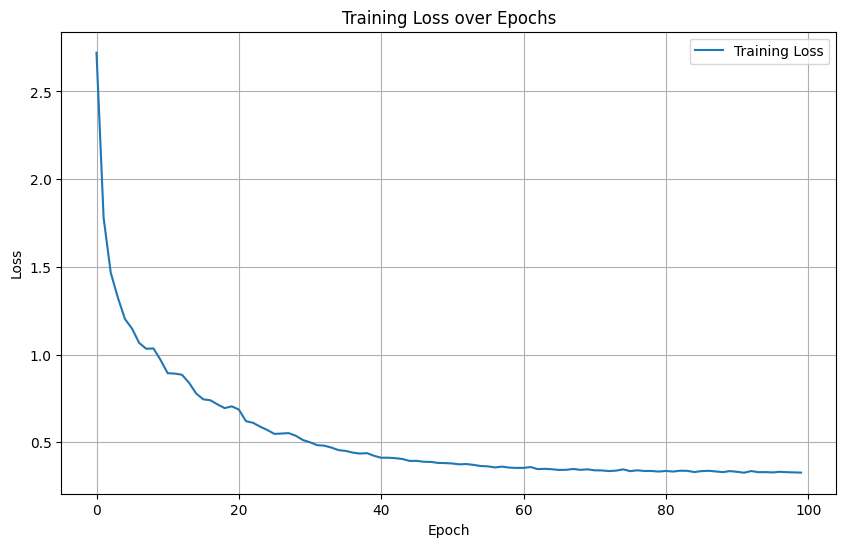

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

----

In [32]:
def compute_similarity_scores(model, data_loader):
    similarities = []
    labels = []
    
    for (acc_batch, gyro_batch), batch_labels in data_loader:
        # get embeddings
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) 
        # get embedding of accel and gyro
        
        # calculate cosine similarity between paired embeddings
        batch_similarities = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        similarities.extend(batch_similarities.numpy())
        labels.extend(batch_labels.numpy())
    
    return np.array(similarities), np.array(labels)

In [33]:
normal_similarities = []
for acc_batch, gyro_batch in tqdm(train_dataset, desc='Computing normal similarities'):
    # train set embedding -> similarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    normal_similarities.extend(sim.numpy())

test_similarities = []
test_pred_labels = []
for (acc_batch, gyro_batch), labels in tqdm(test_dataset, desc='Computing test similarities'):
    # test set embedding -> simiilarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    test_similarities.extend(sim.numpy())
    test_pred_labels.extend(labels.numpy())

Computing test similarities: 100%|████████████| 240/240 [00:16<00:00, 14.45it/s]


In [39]:
def calculate_similarities(model, test_dataset):
    normal_similarities = []
    fall_similarities = []
    
    for (acc_batch, gyro_batch), labels in test_dataset:
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
        
        sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        for sim_score, label in zip(sim.numpy(), labels.numpy()):
            if label == 0:  # normal
                normal_similarities.append(sim_score)
            else:  # fall
                fall_similarities.append(sim_score)
    
    return np.array(normal_similarities), np.array(fall_similarities)

normal_sims, fall_sims = calculate_similarities(model, test_dataset)

print("[ ADL data ]")
print(f"  Mean: {np.mean(normal_sims):.4f}")
print(f"  Std: {np.std(normal_sims):.4f}")
print(f"  Min: {np.min(normal_sims):.4f}")
print(f"  Max: {np.max(normal_sims):.4f}")
for i in range (20) :
    print ('ADL ind', i+1, ':', normal_sims[i])

print ()
print("[ FALL data ]")
print(f"  Mean: {np.mean(fall_sims):.4f}")
print(f"  Std: {np.std(fall_sims):.4f}")
print(f"  Min: {np.min(fall_sims):.4f}")
print(f"  Max: {np.max(fall_sims):.4f}")
for i in range (20) :
    print ('FALL ind', i+1, ':', fall_sims[i])

[ ADL data ]
  Mean: 0.9951
  Std: 0.0015
  Min: 0.9671
  Max: 0.9976
ADL ind 1 : 0.9946265
ADL ind 2 : 0.9952879
ADL ind 3 : 0.99615467
ADL ind 4 : 0.995717
ADL ind 5 : 0.9955928
ADL ind 6 : 0.9955975
ADL ind 7 : 0.99567044
ADL ind 8 : 0.9959919
ADL ind 9 : 0.9949013
ADL ind 10 : 0.9963604
ADL ind 11 : 0.99411213
ADL ind 12 : 0.99446505
ADL ind 13 : 0.99559426
ADL ind 14 : 0.9963188
ADL ind 15 : 0.9957963
ADL ind 16 : 0.9946896
ADL ind 17 : 0.99425143
ADL ind 18 : 0.9957265
ADL ind 19 : 0.9961254
ADL ind 20 : 0.99538404

[ FALL data ]
  Mean: 0.9955
  Std: 0.0016
  Min: 0.9397
  Max: 0.9977
FALL ind 1 : 0.9960091
FALL ind 2 : 0.9960071
FALL ind 3 : 0.996335
FALL ind 4 : 0.99450946
FALL ind 5 : 0.99507356
FALL ind 6 : 0.9950103
FALL ind 7 : 0.9955665
FALL ind 8 : 0.99428463
FALL ind 9 : 0.99502945
FALL ind 10 : 0.99444014
FALL ind 11 : 0.995983
FALL ind 12 : 0.9951836
FALL ind 13 : 0.9944236
FALL ind 14 : 0.9926801
FALL ind 15 : 0.9860575
FALL ind 16 : 0.99615
FALL ind 17 : 0.9961865
F

In [34]:
threshold = np.percentile(normal_similarities, 10)

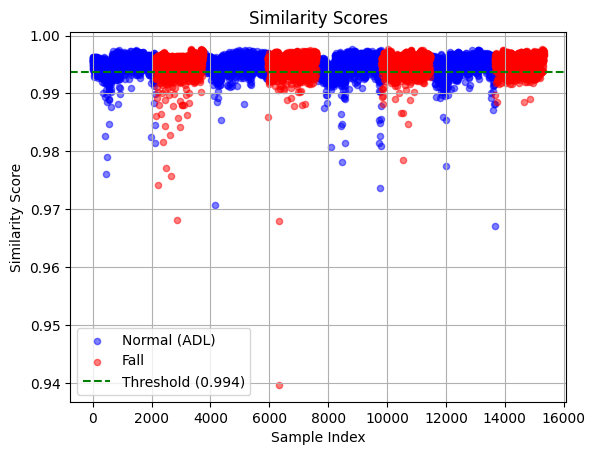

In [35]:
indices = range(len(test_similarities))
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 0], 
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 1],
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.3f})')
# plt.ylim(0.0078100, 0.0078150)
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores')
plt.legend()
plt.grid(True)

In [36]:
predictions = [1 if sim < threshold else 0 for sim in test_similarities] 
true_labels = test_pred_labels

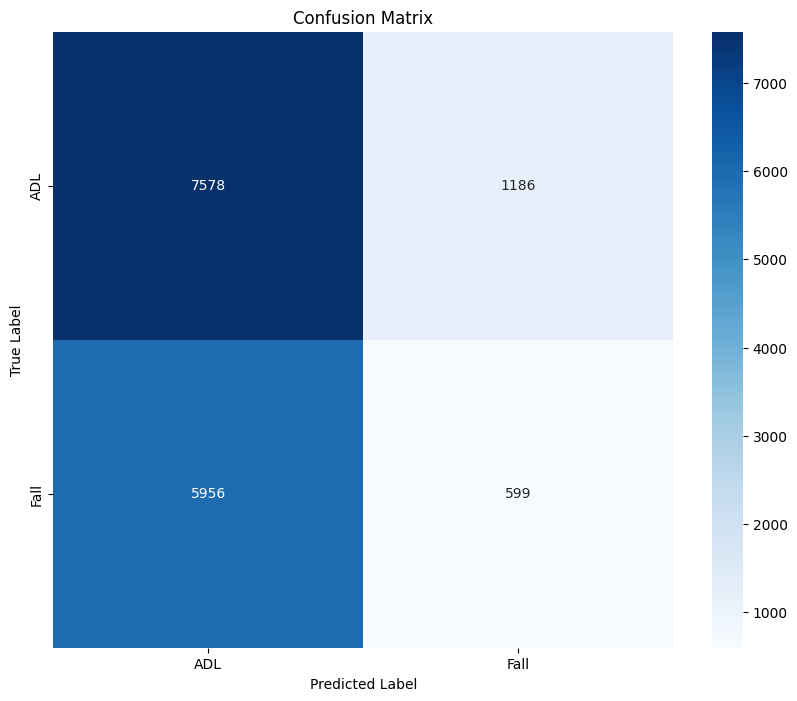

In [37]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
labels = ['ADL', 'Fall']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()

In [38]:
print ("classification report")
print(classification_report(true_labels, predictions, 
                          target_names=['ADL', 'Fall']))

classification report
              precision    recall  f1-score   support

         ADL       0.56      0.86      0.68      8764
        Fall       0.34      0.09      0.14      6555

    accuracy                           0.53     15319
   macro avg       0.45      0.48      0.41     15319
weighted avg       0.46      0.53      0.45     15319

